In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import random
import tensorflow as tf
import tensorflow.keras.layers as tfl

In [2]:
# All mfcc data are contained in numpy_datas, which is a list. 
# The each entry of the list is another list consistes of [mfccs, file name]
MFCCs_DATA = "MFCCsData"
numpy_datas = []

dirlist = os.listdir(MFCCs_DATA)
for d in dirlist:
    d = os.path.join(MFCCs_DATA, d)
    datalist = os.listdir(d)
    datalist = [[np.load(os.path.join(d,x)), os.path.join(d,x)] for x in datalist]
    numpy_datas.extend(datalist)

In [ ]:
numpy_datas[200][0].shape

In [ ]:
numpy_datas[100][0].shape

Notice that the size of mfccs for each emotion file is different, need to resize the data into the same size

In [3]:
# resize into (19,512) then transpose to (512,19) for CNN
for i in range(len(numpy_datas)):
    numpy_datas[i][0] = np.transpose(np.resize(numpy_datas[i][0], (19,512)))

In [ ]:
numpy_datas[200][0].shape

In [ ]:
numpy_datas[100][0].shape

So now all data has the same shape

Separate the data list according to the label. Change file name to correct label. [1,0,0] is angry, [0,1,0] is happy, [0,0,1] is normal.

In [4]:
# change file name to correct label
angry = []
happy = []
normal = []

for i in range(len(numpy_datas)):
    file_name = numpy_datas[i][1]
    if "angry" in file_name:
        numpy_datas[i][1] = np.array([1,0,0])
        angry.append(numpy_datas[i])
    elif "happy" in file_name:
        numpy_datas[i][1] = np.array([0,1,0])
        happy.append(numpy_datas[i])
    else:
        numpy_datas[i][1] = np.array([0,0,1])
        normal.append(numpy_datas[i])

Now split the Train-Valid-Test data with a ratio of 60%-20%-20%

In [5]:
# first shuffle the list of each emotion
random.shuffle(angry)
random.shuffle(happy)
random.shuffle(normal)

In [6]:
# then select the first 180 in each emotion as train data, first 60 in each emotion as valid data, and first 60 in each emotion as test data
train_data = angry[:int(len(angry)*0.6)] + happy[:int(len(happy)*0.6)] + normal[:int(len(normal)*0.6)]
valid_data = angry[int(len(angry)*0.6):int(len(angry)*(0.6+0.2))] + happy[int(len(happy)*0.6):int(len(happy)*(0.6+0.2))] + normal[int(len(normal)*0.6):int(len(normal)*(0.6+0.2))]
test_data = angry[int(len(angry)*(0.6+0.2)):] + happy[int(len(happy)*(0.6+0.2)):] + normal[int(len(normal)*(0.6+0.2)):]
random.shuffle(train_data)
random.shuffle(valid_data)
random.shuffle(test_data)

In [7]:
# train, valid, test data are all in list consistes of [mfccs, file name]
# want to change the list to two outputs:
# X: vector of mfccs
# Y: vector of labels
def data2vector(data):
    X = []
    Y = []
    for i in range(len(data)):
        X.append(data[i][0])
        Y.append(data[i][1])
    X = np.array(X)
    Y = np.array(Y)
    return X,Y

In [8]:
X_train, Y_train = data2vector(train_data)

In [ ]:
print(X_train.shape)
print(Y_train.shape)

In [9]:
X_valid, Y_valid = data2vector(valid_data)
X_test, Y_test = data2vector(test_data)

Now let's do normalization, by the value of train data

In [10]:
X_train_miu = np.average(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)

In [ ]:
print(X_train_miu.shape)
print(X_train_std.shape)

In [ ]:
print(np.average(X_train, axis=0).shape)

In [11]:
X_train_norm = (X_train - X_train_miu)/X_train_std
X_valid_norm = (X_valid - X_train_miu)/X_train_std
X_test_norm = (X_test - X_train_miu)/X_train_std

In [12]:
# convert array to tensor
X_train_norm = tf.convert_to_tensor(X_train_norm)
X_valid_norm = tf.convert_to_tensor(X_valid_norm)
X_test_norm = tf.convert_to_tensor(X_test_norm)
Y_train = tf.convert_to_tensor(Y_train)
Y_valid = tf.convert_to_tensor(Y_valid)
Y_test = tf.convert_to_tensor(Y_test)

In [ ]:
print(X_train_norm.shape)

In [ ]:
# flatten the shape
#X_train_norm_flat = tf.reshape(X_train_norm, [540, -1])
#X_valid_norm_flat = tf.reshape(X_valid_norm, [180, -1])
#X_test_norm_flat = tf.reshape(X_test_norm, [180, -1])

In [39]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Arguments:
    input_mfcc -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_mfcc = tf.keras.Input(shape=input_shape)
    ## CONV1D: 4 filters 8, stride of 1, padding 'SAME'
    Z1 = tfl.Conv1D(filters = 4, kernel_size = 8, strides = 2, padding='same', kernel_initializer = 'he_normal')(input_mfcc)
    ## RELU
    A1 = tfl.ReLU()(Z1)
    ## MAXPOOL: window 8, stride 4, padding 'SAME'
    P1 = tfl.MaxPool1D(pool_size = 8, strides = 4, padding='same')(A1)
    
    ## CONV1D: 2 filters 4, stride 1, padding 'SAME'
    Z2 = tfl.Conv1D(filters = 2, kernel_size = 4, strides = 2, padding='same', kernel_initializer = 'he_normal')(P1)
    ## RELU
    A2 = tfl.ReLU()(Z2)
    ## MAXPOOL: window 4, stride 2, padding 'SAME'
    P2 = tfl.MaxPool1D(pool_size = 4, strides = 2, padding='same')(A2)
    ## FLATTEN
    F = tfl.Flatten()(P2)
    ## Dense layer
    ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tfl.Dense(3, activation='softmax')(F)
    
    model = tf.keras.Model(inputs=input_mfcc, outputs=outputs)
    return model

In [40]:
conv_model = convolutional_model((512, 19))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 512, 19)]         0         
                                                                 
 conv1d_22 (Conv1D)          (None, 256, 4)            612       
                                                                 
 re_lu_22 (ReLU)             (None, 256, 4)            0         
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 64, 4)            0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 32, 2)             34        
                                                                 
 re_lu_23 (ReLU)             (None, 32, 2)             0         
                                                          

In [41]:
history = conv_model.fit(X_train_norm, Y_train, epochs=100, validation_data=(X_valid_norm, Y_valid))

Epoch 1/100
17/17 [==============================] - 1s 40ms/step - loss: 3.5405 - accuracy: 0.2852 - val_loss: 2.8121 - val_accuracy: 0.2833
Epoch 2/100
17/17 [==============================] - 1s 38ms/step - loss: 2.2367 - accuracy: 0.3130 - val_loss: 1.8800 - val_accuracy: 0.3056
Epoch 3/100
17/17 [==============================] - 1s 32ms/step - loss: 1.5514 - accuracy: 0.3481 - val_loss: 1.4300 - val_accuracy: 0.3222
Epoch 4/100
17/17 [==============================] - 0s 25ms/step - loss: 1.2458 - accuracy: 0.3815 - val_loss: 1.2400 - val_accuracy: 0.3333
Epoch 5/100
17/17 [==============================] - 0s 22ms/step - loss: 1.1168 - accuracy: 0.4222 - val_loss: 1.1703 - val_accuracy: 0.3611
Epoch 6/100
17/17 [==============================] - 1s 33ms/step - loss: 1.0576 - accuracy: 0.4519 - val_loss: 1.1396 - val_accuracy: 0.3556
Epoch 7/100
17/17 [==============================] - 0s 23ms/step - loss: 1.0251 - accuracy: 0.4815 - val_loss: 1.1252 - val_accuracy: 0.3444
Epoch 

17/17 [==============================] - 0s 21ms/step - loss: 0.3467 - accuracy: 0.8537 - val_loss: 0.7485 - val_accuracy: 0.6500
Epoch 59/100
17/17 [==============================] - 0s 22ms/step - loss: 0.3431 - accuracy: 0.8519 - val_loss: 0.7650 - val_accuracy: 0.6278
Epoch 60/100
17/17 [==============================] - 0s 25ms/step - loss: 0.3368 - accuracy: 0.8537 - val_loss: 0.7607 - val_accuracy: 0.6222
Epoch 61/100
17/17 [==============================] - 0s 21ms/step - loss: 0.3322 - accuracy: 0.8519 - val_loss: 0.7582 - val_accuracy: 0.6444
Epoch 62/100
17/17 [==============================] - 0s 20ms/step - loss: 0.3300 - accuracy: 0.8574 - val_loss: 0.7744 - val_accuracy: 0.6278
Epoch 63/100
17/17 [==============================] - 0s 21ms/step - loss: 0.3274 - accuracy: 0.8593 - val_loss: 0.7424 - val_accuracy: 0.6444
Epoch 64/100
17/17 [==============================] - 0s 17ms/step - loss: 0.3217 - accuracy: 0.8685 - val_loss: 0.7605 - val_accuracy: 0.6389
Epoch 65/100

C:\Users\zhuq6\AppData\Local\Temp\ipykernel_10424\903421272.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
C:\Users\zhuq6\AppData\Local\Temp\ipykernel_10424\903421272.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

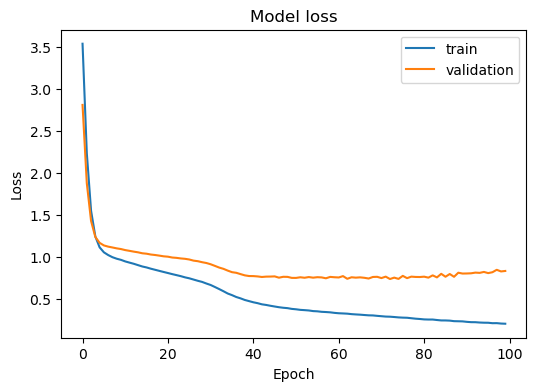

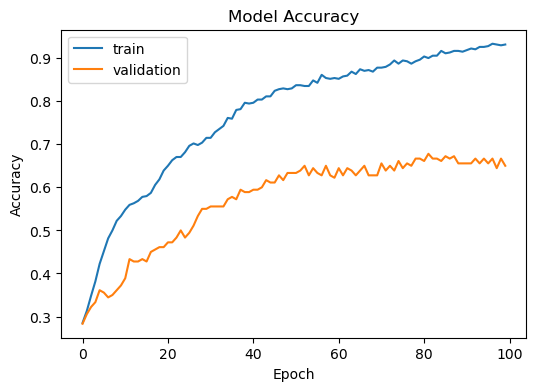

In [42]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')